In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from scipy.optimize import curve_fit

%matplotlib notebook

In [2]:
def read_pars(runID):
    """
    Reads input parameters at file run+runID/pdm.inp and assign them to global variables.
    """
    global LAMBDA_
    global DIM_
    global POTID_
    global N_RGRID_
    global DR_
    global N_AGRID_
    global NSQ_
    global T_HIGH_
    global T_LOW_
    global TAU_MAX_
    global TAU_FINAL_
    
    filename = "./run" + runID + "/pdm.inp"
    file=open(filename,"r")
    parameters = file.readlines()
    
    for i,line in enumerate(parameters):
        line = line.replace("\n","")
        parameters[i] = line
        
    for pars in parameters:
        values = pars.split(" ")
        
        if values[0] == "PHYSI":
            LAMBDA_ = float(values[1])
            DIM_ = int(values[2])
            POTID_ = int(values[3])
            
        if values[0] == "RGRID":
            N_RGRID_ = int(values[1])
            DR_ = float(values[2])
        
        if values[0] == "AGRID":
            N_AGRID_ = int(values[1])
            
        if values[0] == "SQUAR":
            NSQ_ = int(values[1])
            T_HIGH_ = float(values[2])
            TAU_MAX_ = 1. / T_HIGH_
            TAU_FINAL_ = TAU_MAX_ * (2. ** NSQ_)
            T_LOW_ = 1. / TAU_FINAL_    

In [3]:
def freepdm(r1,r2,theta):
    """
    Calculates free-particle DM
    """
    if DIM_==2:
        f=1.0
    elif DIM_==3:
        f=1.5
    else:
        print("Spatial Dimension not supported")
        
    f1 = 1.0 / (4. * np.pi * LAMBDA_ * TAU_FINAL_ )**f
    f2 = np.exp( -(r1*r1 + r2*r2 - 2.0*r1*r2*np.cos(theta)) / (4.0 * LAMBDA_ * TAU_FINAL_) )
    dmf = f1 * f2
    
    return dmf

In [4]:
def inverse_freepdm(r1,r2,theta):
    """
    Calculates the inverse of the free-particle DM (1/)
    """
    if DIM_==2:
        f=1.0
    elif DIM_==3:
        f=1.5
    else:
        print("Spatial dimension not supported")
        
    f1 = (4. * np.pi * LAMBDA_ * TAU_FINAL_ )**f
    f2 = np.exp( (r1*r1 + r2*r2 - 2.0*r1*r2*np.cos(theta)) / (4.0 * LAMBDA_ * TAU_FINAL_) )
    dmf = f1 * f2
    
    return dmf

In [5]:
def read_pdm(runID):
    """
    Reads full density matrix in file run+runID/pdm.csv.
    """
    read_pars(runID)
    filename = "./run" + runID + "/pdm.csv"
    pdm = pd.read_csv(filename,header=None)
    
    return pdm

In [6]:
def get_upair_from_pdm(runID):
    """
    Calculates the pair action associate to file run+runID/pdm.csv.
    """
    read_pars(runID)
    pdm = read_pdm(runID)
    
    pdm = pdm.clip(lower=0) # bye negatives
    freedm = freepdm(pdm[0],pdm[1],pdm[2])
    inv = inverse_freepdm(pdm[0],pdm[1],pdm[2])
    upair = []
    for i in range(len(pdm)):
        x = freedm[i]
        z = inv[i]
        y = pdm[3][i]
        #if x < 0.0000001:
        #    up=0
        #else:
        #    if y == 0:
        #        up=100000
        #    else:
                #up = -np.log(pdm[3][i] / x)
        up = -np.log(y * z)
        upair.append(up)
    
    pdm[4] = upair
    #pdm[4] = pdm[4].replace(np.inf, 100000) 
    #upair = -np.log(pdm[3]/freedm)
    #upair = upair.replace(-np.inf, 100000)  # bye infinites
    #pdm[4] = upair
    
    return pdm

In [7]:
def write_upair(runID):
    """
    Writes the pair action associated to file run+runID/pdm.csv to file run+runID/upair.csv.
    """
    pdm = get_upair_from_pdm(runID)
    filename="./run" + runID + "/upair.csv"
    pdm.to_csv(filename,columns=[0,1,2,4],header=False,index=False)
    
    return

In [8]:
def trim_and_write_upair(runID):
    """
    Trims the pair action associated to file run+runID/pdm.csv and writes it to file run+runID/upair_restricted.csv.
    """
    pdm = get_upair_from_pdm(runID)
    pdm = pdm[pdm[1] <= pdm[0]]
    #twl = np.sqrt(2.* LAMBDA_ * TAU_FINAL_ )
    #pdm = pdm[pdm[1] >= pdm[0] - 3.*twl]
    filename="./run" + runID + "/upair_triangular.csv"
    pdm.to_csv(filename,columns=[0,1,2,4],header=False,index=False)
    
    return

In [9]:
def plot_pdm(runID, thetaID):
    """
    Plots the full density matrix in file run+runID/pdm.csv for a fixed theta=agrid[thetaID].
    """
    pdm = read_pdm(runID)
    rgrid = pdm[0].unique()
    agrid = pdm[2].unique()
    theta = agrid[thetaID]
    pdmt = pdm.loc[pdm[2] == theta]
    pdmt = np.array(pdmt)
    rho = pdmt[:,3]
    rho=np.reshape(rho, (len(rgrid),len(rgrid)))
    
    plt.figure(figsize=(8,8))
    plt.pcolormesh(rgrid, rgrid, rho, cmap='Greens_r')
    plt.axes().set_aspect('equal', adjustable='box')
    plt.axes().autoscale_view()
    plt.tick_params(labelsize=18)
    plt.title(r'$\theta = %.2f$, $T=%d$ K' % (theta,T_LOW_), fontsize=20)
    plt.xlabel(r'$r_1$',fontsize=20)
    plt.ylabel(r'$r_2$',fontsize=20)
    cbar = plt.colorbar()
    cbar.set_label(r'$\rho(r_1, r_2, \theta; \beta)$', fontsize=22)
    cbar.ax.tick_params(labelsize=18)

In [10]:
def plot_pwave(runID,l):
    
    read_pars(runID)
    fname = "./run"+ runID + "/pwl" + str(l) + ".csv"
    pw = pd.read_csv(fname, header=None)

    rgrid = pw[0].unique()
    pw = np.array(pw)
    rho = np.reshape(pw[:,2], (len(rgrid),len(rgrid)))

    plt.figure(figsize=(8,8))
    plt.pcolormesh(rgrid, rgrid, rho, cmap='Reds_r')
    plt.axes().set_aspect('equal', adjustable='box')
    plt.axes().autoscale_view()
    plt.tick_params(labelsize=18)
    plt.title(r'$\ell=%d$, $T=%d$ K' % (l, T_LOW_), fontsize=20)
    plt.xlabel(r'$r_1$',fontsize=20)
    plt.ylabel(r'$r_2$',fontsize=20)
    cbar = plt.colorbar()
    cbar.set_label(r'$\rho_{%d} (r_1, r_2; \beta)$' % l, fontsize=22)
    cbar.ax.tick_params(labelsize=18)

In [11]:
def plot_upair(runID, thetaID):
    """
    Plots the full pair action from pdm in file run+runID/pdm.csv for a fixed theta=agrid[thetaID].
    """
    pdm = get_upair_from_pdm(runID)
    rgrid = pdm[0].unique()
    agrid = pdm[2].unique()
    theta = agrid[thetaID]
    pdmt = pdm.loc[pdm[2] == theta]
    pdmt = np.array(pdmt)
    up = pdmt[:,4]
    up=np.reshape(up, (len(rgrid),len(rgrid)))
    
    plt.figure(figsize=(8,8))
    plt.pcolormesh(rgrid, rgrid, up, cmap='Blues_r',vmax=3)
    plt.axes().set_aspect('equal', adjustable='box')
    plt.axes().autoscale_view()
    plt.tick_params(labelsize=18)
    plt.title(r'$\theta = %.2f$, $T=%d$ K' % (theta,T_LOW_), fontsize=20)
    plt.xlabel(r'$r_1$',fontsize=20)
    plt.ylabel(r'$r_2$',fontsize=20)
    cbar = plt.colorbar()
    cbar.set_label(r'$u_{pair}(r_1, r_2, \theta; \beta)$', fontsize=22)
    cbar.ax.tick_params(labelsize=18)

# POTENTIALS

In [32]:
def pot_Aziz(r):
    a=186924.404
    alpha=10.5717543
    beta=-2.07758779
    d=1.438
    rm=0.29683
    eps=10.956
    c6=1.35186623
    c8=.41495143
    c10=.17151143
    
    rm2=rm**2
    rm3=rm*rm2
    rm6=rm3*rm3
    rm8=rm6*rm2
    rm10=rm8*rm2
    epsa=eps*a
    ac=alpha/rm
    b2=-beta/rm2
    drm=d*rm
    epsc6=eps*c6*rm6
    epsc8=eps*c8*rm8
    epsc10=eps*c10*rm10
      
    sgmnm = 0.2556

    r = r*sgmnm
    oor = 1./r
    oor2 = oor**2
    oor6 = oor2**3
    v = epsa * np.exp ((-ac - b2*r)*r)
    if (r < drm):
        v = v - (epsc6+(epsc8+epsc10*oor2)*oor2)*oor6*np.exp(-(drm*oor-1.)**2)
    else:
        v = v - (epsc6+(epsc8+epsc10*oor2)*oor2)*oor6

    return v

def pot_LJ(r):
    sigma=0.2556
    epsilon=10.22
    
    oor = 1./r
    oor6 = oor**6
    
    v = 4. * epsilon * oor6*(oor6 - 1.)
    
    return v

<IPython.core.display.Javascript object>


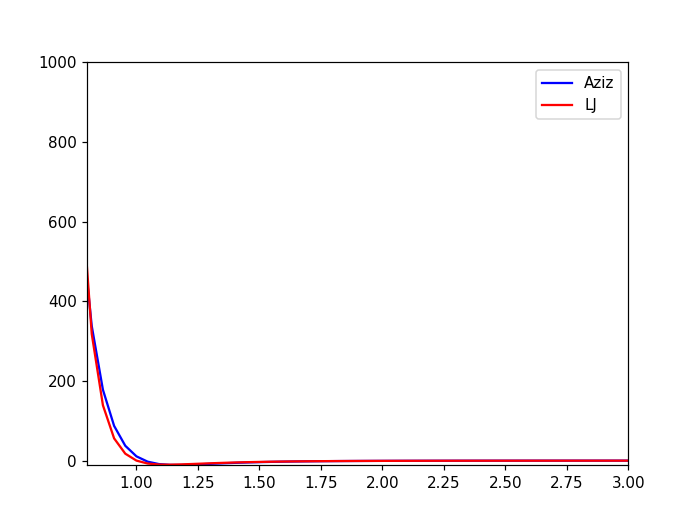

In [43]:
x = np.linspace(0.5,5,100)
y = []
z = []
for r in x:
    v = pot_Aziz(r)
    y.append(v)
    v = pot_LJ(r)
    z.append(v)
y = np.array(y)
plt.figure()
plt.plot(x,y,label='Aziz',color='blue')
plt.plot(x,z,label='LJ',color='red')
#plt.plot(x,y-z,label='difference',color='green')
plt.ylim(-12,1000)
plt.xlim(0.8,3)
plt.legend()

# PRIMITIVE DM

In [45]:
def primitive_dm(runID):
    read_pars(runID)
    pdm = read_pdm(runID)
    freedm = freepdm(pdm[0],pdm[1],pdm[2])
    primitive_dm = []
    for i in range(len(freedm)):
        pot = pot_Aziz(pdm[0][i]) + pot_Aziz(pdm[1][i])
        pot = -TAU_FINAL_ * pot / 2.0
        prim = freedm[i] * np.exp(pot)
        primitive_dm.append(prim)
    
    return primitive_dm

In [46]:
def compare_pdm(runID,thetaID):
    read_pars(runID)
    pdm = read_pdm(runID)
    pdm[4] = primitive_dm(runID)
    
    rgrid = pdm[0].unique()
    agrid = pdm[2].unique()
    theta = agrid[thetaID]
    pdmt = pdm.loc[pdm[2] == theta]
    pdmt = np.array(pdmt)
    rho = pdmt[:,3]
    rho=np.reshape(rho, (len(rgrid),len(rgrid)))
    rho_p = pdmt[:,4]
    rho_p=np.reshape(rho_p, (len(rgrid),len(rgrid)))
    what = rho - rho_p
    lim = np.amax(np.absolute(what))
    
    plt.figure(figsize=(8,8))
    plt.pcolormesh(rgrid, rgrid, what, cmap='seismic_r',vmin=-lim,vmax=lim)
    plt.axes().set_aspect('equal', adjustable='box')
    plt.axes().autoscale_view()
    plt.tick_params(labelsize=18)
    plt.title(r'$\theta = %.2f$, $T=%d$ K' % (theta,T_LOW_), fontsize=20)
    plt.xlabel(r'$r_1$',fontsize=20)
    plt.ylabel(r'$r_2$',fontsize=20)
    cbar = plt.colorbar()
    cbar.set_label(r'$\rho - \rho_{prim}$', fontsize=24)
    cbar.ax.tick_params(labelsize=18)
    
    
    return 

<IPython.core.display.Javascript object>


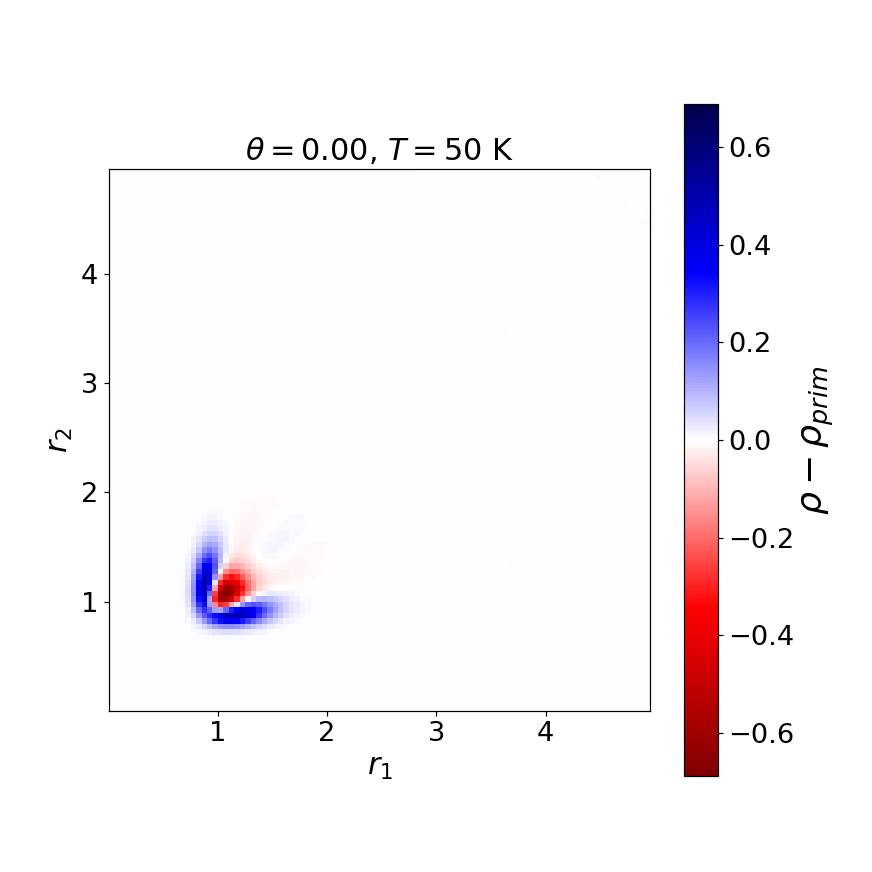

<ipython-input-46-6bbdd051987a>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(rgrid, rgrid, what, cmap='seismic_r',vmin=-lim,vmax=lim)
<ipython-input-46-6bbdd051987a>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal', adjustable='box')
<ipython-input-46-6bbdd051987a>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance

In [47]:
compare_pdm('074',0)

In [60]:
prim = primitive_dm('047')
pdm = read_pdm('047')
pdm[3] = prim

In [61]:
pdm

,0,1,2,3
0,0.05,0.05,0,0.000000
1,0.05,0.10,0,0.000000
2,0.05,0.15,0,0.000000
3,0.05,0.20,0,0.000000
4,0.05,0.25,0,0.000000
...,...,...,...,...
9995,5.00,4.80,0,6.221965
9996,5.00,4.85,0,8.305207
9997,5.00,4.90,0,10.207943
9998,5.00,4.95,0,11.552897


In [62]:
filename="./run047_prim/pdm.csv"
pdm.to_csv(filename,columns=[0,1,2,3],header=False,index=False)

# AUXILIARY VARIABLES

In [ ]:
# reading, dropping zeros
pwc=10**-5
runID = '078'
df = get_upair_from_pdm(runID)
df.columns=['r1','r2','th','rho','up']
df_R = df[df['rho'] >= pwc]
df = df_R
df.reset_index(inplace=True,drop=True)

# auxiliary variables
df['q'] = 0.5 * (df['r1'] + df['r2'])
df['z'] = df['r1'] - df['r2']
df['s'] = np.sqrt(df['r1']*df['r1'] + df['r2']*df['r2'] - 2.*df['r1']*df['r2']*np.cos(df['th']))

# getting diagonal part
df_diag = df[df['s']==0] 
df_diag.reset_index(inplace=True,drop=True)

/home/babreu/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-6-c10cff05a9c1>:23: RuntimeWarning: divide by zero encountered in log
  up = -np.log(y * z)
<ipython-input-6-c10cff05a9c1>:23: RuntimeWarning: invalid value encountered in double_scalars
  up = -np.log(y * z)


### check on a single surface

In [47]:
# creates power expansion in s, z
def objective(xdata_tuple ,u10, u11, u20, u21, u22):
    (s,z) = xdata_tuple
    uod = u10*s*s + u11*z*z + u20*s*s*s*s + u21*s*s*z*z + u22*z*z*z*z
    return uod

In [50]:
qf = df_diag['q'][0]
print(qf)
dq = 0.00001
qup = qf + dq
qdown = qf - dq

#df_od = pd.DataFrame(df[df['q'] == qf])
df_od = pd.DataFrame(df[df['q'] <= qup])
df_od = pd.DataFrame(df_od[df_od['q'] >= qdown])
df_od.reset_index(inplace=True,drop=True)
print(len(df_od))

r_min = df_diag['r1'].min(axis=0)
df_od = df_od[df_od['r1'] >= r_min]
r_min = df_diag['r2'].min(axis=0)
df_od = df_od[df_od['r2'] >= r_min]
df_od.reset_index(inplace=True,drop=True)
print(len(df_od))

uod=[]
for i in range(len(df_od)):
    r1 = df_od['r1'][i]
    ud1 = float(df_diag['up'][df_diag['q']==r1])
    r2 = df_od['r2'][i]
    ud2 = float(df_diag['up'][df_diag['q']==r2])
    uf = df_od['up'][i] - 0.5*(ud1 + ud2)
    uod.append(uf)
    
df_od['uod'] = uod

# fit
s = np.array(df_od['s'])
z = np.array(df_od['z'])
uod = np.array(df_od['uod'])
popt, _ = curve_fit(obj2,(s,z),uod)

u_fit = objective((s,z),popt[0],popt[1],popt[2],popt[3],popt[4])

1.6840000000000002
11
3


TypeError: Improper input: N=5 must not exceed M=3

<IPython.core.display.Javascript object>


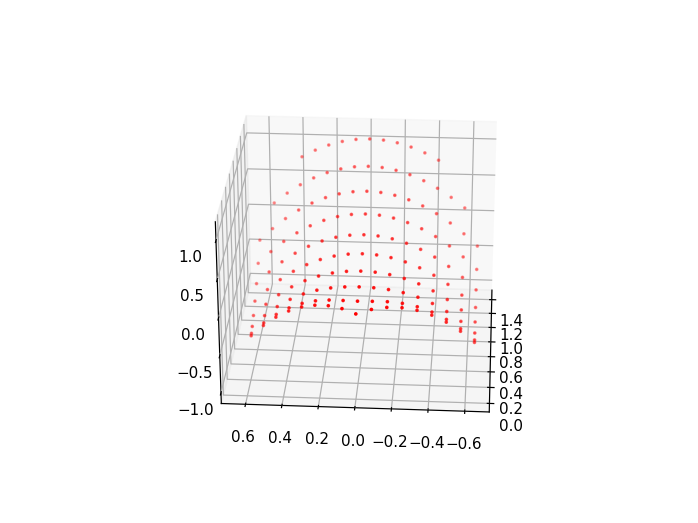

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter3D(s, z, u_fit, c='blue', s=2)
ax.scatter3D(s, z, df_od['uod'], c='red', s=2)

## fit multiple surfaces

In [104]:
# creates power expansion in s, z

#first order
#fit_order = 1
def obj1(xdata_tuple ,u10, u11):
    (s,z) = xdata_tuple
    uod = u10*s*s + u11*z*z 
    return uod

#second order
#fit_order = 2
def obj2(xdata_tuple ,u10, u11, u20, u21, u22):
    (s,z) = xdata_tuple
    uod = u10*s*s + u11*z*z + u20*s*s*s*s + u21*s*s*z*z + u22*z*z*z*z
    return uod

In [105]:
fit_order=2
dq = 0.00001
uij = []
ud = []
q = []
for j in range(len(df_diag)):
    qf = df_diag['q'][j]
    qup = qf + dq
    qdown = qf - dq

#df_od = pd.DataFrame(df[df['q'] == qf])
    df_od = pd.DataFrame(df[df['q'] <= qup])
    df_od = pd.DataFrame(df_od[df_od['q'] >= qdown])
    df_od.reset_index(inplace=True,drop=True)
    
    #df_od = pd.DataFrame(df[df['q'] == qf])
    #df_od.reset_index(inplace=True,drop=True)

    r_min = df_diag['r1'].min(axis=0)
    df_od = df_od[df_od['r1'] >= r_min]
    r_min = df_diag['r2'].min(axis=0)
    df_od = df_od[df_od['r2'] >= r_min]
    df_od.reset_index(inplace=True,drop=True)

    uod=[]
    for i in range(len(df_od)):
        r1 = df_od['r1'][i]
        ud1 = float(df_diag['up'][df_diag['q']==r1])
        r2 = df_od['r2'][i]
        ud2 = float(df_diag['up'][df_diag['q']==r2])
        uf = df_od['up'][i] - 0.5*(ud1 + ud2)
        uod.append(uf)
    
    df_od['uod'] = uod
    if(len(df_od) > 5):
        s = np.array(df_od['s'])
        z = np.array(df_od['z'])
        uod = np.array(df_od['uod'])
        if(fit_order==1):
            popt, _ = curve_fit(obj1,(s,z),uod)
        elif (fit_order==2):
            popt, _ = curve_fit(obj2,(s,z),uod)
        uij.append(popt)
        q.append(qf)
    #ud = df_diag['up'][i]
        ud.append(df_diag['up'][j])

<IPython.core.display.Javascript object>


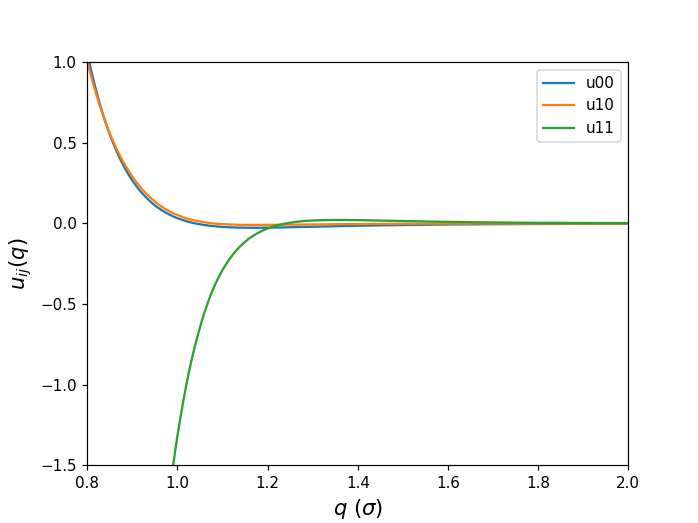

In [106]:
x = np.array(uij)

q = np.array(q)
u00 = np.array(ud)
u10 = x[:,0]
u11 = x[:,1]
#u20 = x[:,2]
#u21 = x[:,3]
#u22 = x[:,4]

# plot
fig = plt.figure()
plt.plot(q,u00,label='u00')
plt.plot(q,u10,label='u10')
plt.plot(q,u11,label='u11')
#plt.plot(q,u20,label='u20')
#plt.plot(q,u21,label='u21')
#plt.plot(q,u22,label='u22')
plt.xlim(0.8,2)
plt.ylim(-1.5,1)
plt.xlabel(r'$q$ $(\sigma)$',fontsize=14)
plt.ylabel(r'$u_{ij}(q)$', fontsize=14)
plt.legend()

In [107]:
# off diagonal write
filename = "./run" + runID + "/uod.csv"

df = pd.DataFrame(uij)
df.columns = ['u10', 'u11', 'u20', 'u21', 'u22']
df['q'] = q
df = df[df['q'] >= 0.704]
df = df[df['q'] <= 2.347]
df.to_csv(filename, index=False)

# diagonal write
filename = "./run" + runID + "/ud.csv"

df = pd.DataFrame(u00)
df.columns = ['u00']
df['q'] = q
df = df[df['q'] >= 0.704]
df = df[df['q'] <= 2.347]
df.to_csv(filename, index=False)

# SCIPY LINALG

In [44]:
import scipy as sp

In [49]:
uij = []
for i in range(len(df_diag)):
    qf = df_diag['q'][i]
    
    df_qf = pd.DataFrame(df[df['q'] == qf])
    df_qf.reset_index(inplace=True,drop=True)

    r_min = df_diag['r1'].min(axis=0)
    df_qf = df_qf[df_qf['r1'] >= r_min]
    r_min = df_diag['r2'].min(axis=0)
    df_qf = df_qf[df_qf['r2'] >= r_min]
    df_qf.reset_index(inplace=True,drop=True)

    uod=[]
    for i in range(len(df_qf)):
        r1 = df_qf['r1'][i]
        ud1 = float(df_diag['up'][df_diag['q']==r1])
        r2 = df_qf['r2'][i]
        ud2 = float(df_diag['up'][df_diag['q']==r2])
        uf = df_qf['up'][i] - 0.5*(ud1 + ud2)
        uod.append(uf)
    
    df_qf['uod'] = uod

    s = np.array(df_qf['s'])
    z = np.array(df_qf['z'])
    uod = np.array(df_qf['uod'])
    
    M = np.array(s*s)
    M = np.column_stack((M,z*z))
    M = np.column_stack((M,s*s*s*s))
    M = np.column_stack((M,s*s*z*z))
    M = np.column_stack((M,z*z*z*z))
    
    p, res, rnk, s = sp.linalg.lstsq(M, uod)
    uij.append(p)


# OMP Analysis

In [55]:
%cd optruns

/home/babreu/Science/Physics/pdms/proj_s2v/optruns


In [56]:
pdm1=read_pdm('011')

In [57]:
pdm16=read_pdm('010')

In [61]:
x = pdm1[3] - pdm16[3]

In [64]:
x.sum()

0.0

<ipython-input-9-7268b015f615>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(rgrid, rgrid, rho, cmap='Greens_r')
<ipython-input-9-7268b015f615>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal', adjustable='box')
<ipython-input-9-7268b015f615>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, 

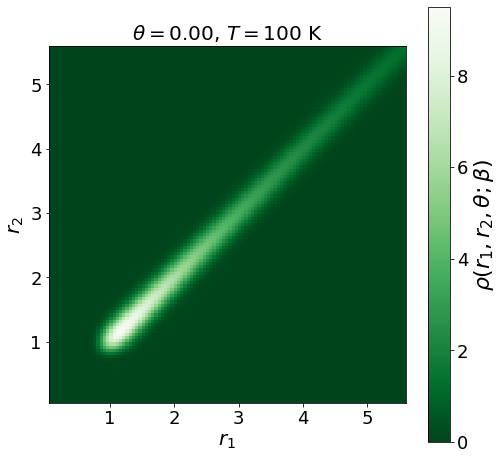

In [65]:
plot_pdm('011', 0)

<ipython-input-9-7268b015f615>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(rgrid, rgrid, rho, cmap='Greens_r')
<ipython-input-9-7268b015f615>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal', adjustable='box')
<ipython-input-9-7268b015f615>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, 

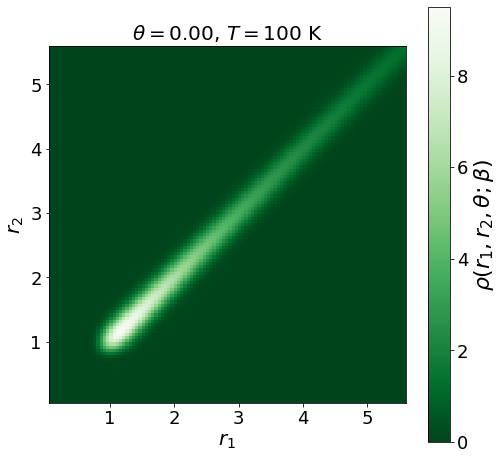

In [66]:
plot_pdm('010', 0)

Text(0.5, 1.0, 'PDM++ OpenMP Scaling')

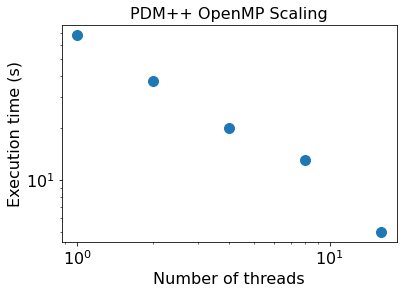

In [81]:
# 1 squaring, 16 waves, NA=16, NGRID=112
threads = [1, 2, 4, 8, 16]
time = [69, 37, 20, 13, 5]
plt.figure()
plt.plot(threads,time, 'o', markersize=10)
plt.xlabel('Number of threads', fontsize=16)
plt.ylabel('Execution time (s)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.title('PDM++ OpenMP Scaling', fontsize=16)